# Astro 531 -- Stellar Evolution -- Homework 4
## Jacob Lustig-Yaeger
### Problems 12.4a-b, 13.1, 14.1

In [104]:
# Import some fundamental python packages
%matplotlib inline
import os
import numpy as np
import scipy as sp
import pdb
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=25, usetex=True)

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rcParams['font.size'] = 15.0

In [74]:
from jakely import colorize

In [172]:
Rsun = 7e10
Msun = 2e33
Lsun = 3.6e33
c = 3e10

## Problem 12.4  
**a) Plot the two versions of the IMF (Kroupa and Chabrier) in terms of log(N)dm vs. log(m), in the range of 0.01 - 100 $M_{\odot}$.**   

In [143]:
def kroupaIMF(m):
    C1 = 1./23.8; C2 = 1./12.45; C3 = 1.0
    if m > 0.5:
        return C1 * m**-2.3
    elif (m >= 0.08) & (m <= 0.5):
        return C2 * m**-1.3
    elif (m < 0.08) & (m > 0.0):
        return C3 * m**-0.3
    else:
        print("Error: invalid mass!")
        return

# Vectorize function for speed!
kroupaIMF = np.vectorize(kroupaIMF)

In [157]:
def chabrierIMF(m):
    D1 = 1.0/6.72; D2 = 1.0/23.8
    if (m <= 1.0) & (m > 0.0):
        return (D1/m) * np.exp(-(np.log10(m/0.08)**2)/0.952)
    elif m > 1.0:
        return D2 * m**-2.3
    else:
        print("Error: invalid mass!")
        return 

# Vectorize function for speed!
chabrierIMF = np.vectorize(chabrierIMF)

In [164]:
mass_grid = np.linspace(0.01, 100., 10000)
Ndm_kroupa = kroupaIMF(mass_grid)
Ndm_chabrier = chabrierIMF(mass_grid)

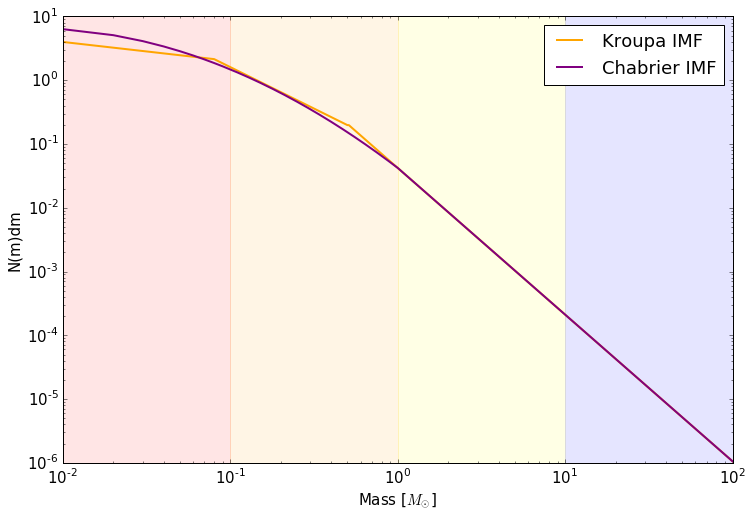

In [165]:
# Plot
fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(1,1) 
ax0 = plt.subplot(gs[0])
ax0.plot(mass_grid,Ndm_kroupa, lw=2.0, c='orange', label="Kroupa IMF")     
ax0.plot(mass_grid,Ndm_chabrier, lw=2.0, c='purple', label="Chabrier IMF")       
ax0.set_xlabel(r'Mass [$M_{\odot}$]')
ax0.set_ylabel(r"N(m)dm")
ax0.loglog()
ax0.axvspan(0.01, 0.1, color='red', alpha=0.1)
ax0.axvspan(0.1, 1.0, color='orange', alpha=0.1)
ax0.axvspan(1.0, 10.0, color='yellow', alpha=0.1)
ax0.axvspan(10.0, 100.0, color='blue', alpha=0.1)
l = ax0.legend(loc=1)

plt.show();

**b) Which fraction of the mass us in the range of 0.01-0.1, 0.1-1.0, 1.0-10.0, 10.0-100.0 in the two IMFs?**  

$$ f = \frac{\int_{\text{min}(m)}^{{\text{max}(m)}} m N(m)dm}{\int_{0.01}^{100} m N(m)dm} $$

In [160]:
# Define mass weighted IMFs

def mN_kroupa(m):
    return m * kroupaIMF(m)

def mN_chabrier(m):
    return m * chabrierIMF(m)

In [161]:
from scipy import integrate

def integrate_kroupa(Mmin, Mmax):
    return integrate.quad(mN_kroupa, Mmin, Mmax)[0]

def integrate_chabrier(Mmin, Mmax):
    return integrate.quad(mN_chabrier, Mmin, Mmax)[0]

In [162]:
# Calculate total N
tot_kroupa = integrate_kroupa(0.01, 100.0)
tot_chabrier = integrate_chabrier(0.01, 100.0)

# Calcuate fractions for Kroupa IMF
fk1 = integrate_kroupa(0.01, 0.1) / tot_kroupa
fk2 = integrate_kroupa(0.1, 1.) / tot_kroupa
fk3 = integrate_kroupa(1., 10.) / tot_kroupa
fk4 = integrate_kroupa(10., 100.) / tot_kroupa

# Calcuate fractions for Chabrier IMF
fc1 = integrate_chabrier(0.01, 0.1) / tot_chabrier
fc2 = integrate_chabrier(0.1, 1.) / tot_chabrier
fc3 = integrate_chabrier(1., 10.) / tot_chabrier
fc4 = integrate_chabrier(10., 100.) / tot_chabrier

In [163]:
print("Fraction of mass in range:\n")
print("----- Kroupa IMF -----")
print("0.01 - 0.1 :"), fk1 
print("0.1 - 1 :"), fk2
print("1 - 10 :"), fk3
print("10 - 100 :"), fk4
print("\n----- Chabrier IMF -----")
print("0.01 - 0.1 :"), fc1 
print("0.1 - 1 :"), fc2
print("1 - 10 :"), fc3
print("10 - 100 :"), fc4

Fraction of mass in range:

----- Kroupa IMF -----
0.01 - 0.1 : 0.0566472070337
0.1 - 1 : 0.408535654201
1 - 10 : 0.356262790895
10 - 100 : 0.178554362613

----- Chabrier IMF -----
0.01 - 0.1 : 0.0639174830157
0.1 - 1 : 0.37930936599
1 - 10 : 0.370888545827
10 - 100 : 0.185884604267


## Problem 13.1  
**Calculate the displacement (in terms of $\Delta \log T_{eff}$ and $\Delta \log R$) of stars 1, 3, 9, 20, and 40 solar masses on the ZAMS if:**  

**i) The helium abundance changes from Y=0.28 to Y=0.38**    
    
>For these relations we will treat the masses in two bins: those between $1 \le M \le 10$ and those $M > 10$. Since the stellar mass doesn't change appreciably, the mass dependent terms will subtract out in the $\Delta \log$. 

In [128]:
def calc_mu(X,Y,Z):
    # (approximate) assuming fully ionized
    return (2.*X + (3.*Y/4.) + (Z/2.))**-1

def ZAMS_logR(M, mu, X, Z):
    if (M >= 1.0) & (M <= 10.0):
        return 0.08*np.log10(M) - 0.54*np.log10(mu) + 0.13*np.log10(Z)
    elif (M > 10.0):
        return 0.8*np.log10(M) + (2./3.)*np.log10(mu) + 0.05*np.log10(1.+X)
    else:
        print("Error: Invalid mass")
        return

def ZAMS_logT(M, mu, X, Z):
    if (M >= 1.0) & (M <= 10.0):
        return 1.26*np.log10(M) + 2.1*np.log10(mu) - 0.31*np.log10(Z)
    elif (M > 10.0):
        return 0.31*np.log10(M) + (2./3.)*np.log10(mu) + (0.25)*np.log10(1.+X)
    else:
        print("Error: Invalid mass")
        return

def ZAMS_logL(M, mu, X, Z):
    if (M >= 1.0) & (M <= 10.0):
        return 5.2*np.log10(M) + 7.5*np.log10(mu) + 0.13*np.log10(Z)
    elif (M > 10.0):
        return 3.0*np.log10(M) + 4.0*np.log10(mu) + np.log10(1.0+X)
    else:
        print("Error: Invalid mass")
        return
    
def ZAMS_logL2(M, mu, X, Z, R):
    if (M >= 1.0) & (M <= 10.0):
        return 5.5*np.log10(M) + 7.5*np.log10(mu) - np.log10(Z) - 0.5*np.log10(R)
    elif (M > 10.0):
        return 3.0*np.log10(M) + 4.0*np.log10(mu) + np.log10(1.0+X)
    else:
        print("Error: Invalid mass")
        return

In [71]:
X1, Y1, Z1 = 0.72, 0.28, 0.02
X2, Y2, Z2 = 0.62, 0.38, 0.02

mu1 = calc_mu(X1, Y1, Z1)
mu2 = calc_mu(X2, Y2, Z2)

print "Initial mu = ", mu1
print "Final mu   = ", mu2

print "1 < M < 10 : DlogT = ", ZAMS_logT(1.0, mu2, X2, Z2) - ZAMS_logT(1.0, mu1, X1, Z1)
print "M > 10     : DlogT = ", ZAMS_logT(12.0, mu2, X2, Z2) - ZAMS_logT(12.0, mu1, X1, Z1)

print "1 < M < 10 : DlogR = ", ZAMS_logR(1.0, mu2, X2, Z2) - ZAMS_logR(1.0, mu1, X1, Z1)
print "M > 10     : DlogR = ", ZAMS_logR(12.0, mu2, X2, Z2) - ZAMS_logR(12.0, mu1, X1, Z1)

Initial mu =  0.602409638554
Final mu   =  0.651465798046
1 < M < 10 : DlogT =  0.0713993872764
M > 10     : DlogT =  0.01616311406
1 < M < 10 : DlogR =  -0.0183598424425
M > 10     : DlogR =  0.021365800533


**ii) The metal abundance changes from Z=0.02 to Z=0.001 (which is the mean metallicity of galactic globular clusters)**  

In [72]:
X1, Y1, Z1 = 0.72, 0.28, 0.02
X2, Y2, Z2 = 0.72, 0.28, 0.001

mu1 = calc_mu(X1, Y1, Z1)
mu2 = calc_mu(X2, Y2, Z2)

print "Initial mu = ", mu1
print "Final mu   = ", mu2

print "1 < M < 10 : DlogT = ", ZAMS_logT(1.0, mu2, X2, Z2) - ZAMS_logT(1.0, mu1, X1, Z1)
print "M > 10     : DlogT = ", ZAMS_logT(12.0, mu2, X2, Z2) - ZAMS_logT(12.0, mu1, X1, Z1)

print "1 < M < 10 : DlogR = ", ZAMS_logR(1.0, mu2, X2, Z2) - ZAMS_logR(1.0, mu1, X1, Z1)
print "M > 10     : DlogR = ", ZAMS_logR(12.0, mu2, X2, Z2) - ZAMS_logR(12.0, mu1, X1, Z1)

Initial mu =  0.602409638554
Final mu   =  0.605877006968
1 < M < 10 : DlogT =  0.408553673341
M > 10     : DlogT =  0.00166170624915
1 < M < 10 : DlogR =  -0.170479881498
M > 10     : DlogR =  0.00166170624915


**iii) Use the values of $M, L, T_{eff}$ from the models for solar metallicity (from appendix C2) and plot the three ZAMS based on stars of 1,3,9,20, and 40 solar masses for: **  
    **a. solar abundance: X,Y,Z = 0.68, 0.3, 0.02**  
    **b. increased helium abundance: X,Y,Z = 0.58, 0.40, 0.02**  
    **c. decreased metal abundance: X,Y,Z = 0.7, 0.3, 0.001**

In [84]:
M  = np.array([1.0, 3.0, 9.0, 20.0, 40.0])
logL = np.array([-.163, 1.909, 3.617, 4.650, 5.373])
logT = np.array([3.751, 4.088, 4.383, 4.544, 4.640])
R = np.array([0.871, 2.004, 3.681, 5.760, 8.510])

In [119]:
R_scale = np.zeros([2, len(M)])

for i in range(len(M)):
    R_scale[0,i] = 10**(np.log10(R[i] * Rsun) + ZAMS_logR(M[i], mu2, X2, Z2) - ZAMS_logR(M[i], mu1, X1, Z1)) / Rsun
    R_scale[1,i] = 10**(np.log10(R[i] * Rsun) + ZAMS_logR(M[i], mu3, X3, Z3) - ZAMS_logR(M[i], mu1, X1, Z1)) / Rsun

In [129]:
# Use solar values to scale to non-solar
X1, Y1, Z1 = 0.68, 0.3, 0.02
X2, Y2, Z2 = 0.58, 0.4, 0.02
X3, Y3, Z3 = 0.70, 0.3, 0.001

# Calculate mean molec. weights
mu1 = calc_mu(X1, Y1, Z1)
mu2 = calc_mu(X2, Y2, Z2)
mu3 = calc_mu(X3, Y3, Z3)

# Define grid to store scaled values
logL_scale = np.zeros([2, len(M)])
logT_scale = np.zeros([2, len(M)])

# loop over masses 
for i in range(len(M)):
    logL_scale[0,i] = logL[i] + (ZAMS_logL2(M[i], mu2, X2, Z2, R_scale[0,i]) - ZAMS_logL2(M[i], mu1, X1, Z1, R[i]))
    logL_scale[1,i] = logL[i] + (ZAMS_logL2(M[i], mu3, X3, Z3, R_scale[1,i]) - ZAMS_logL2(M[i], mu1, X1, Z1, R[i]))
    logT_scale[0,i] = logT[i] + (ZAMS_logT(M[i], mu2, X2, Z2) - ZAMS_logT(M[i], mu1, X1, Z1))
    logT_scale[1,i] = logT[i] + (ZAMS_logT(M[i], mu3, X3, Z3) - ZAMS_logT(M[i], mu1, X1, Z1))

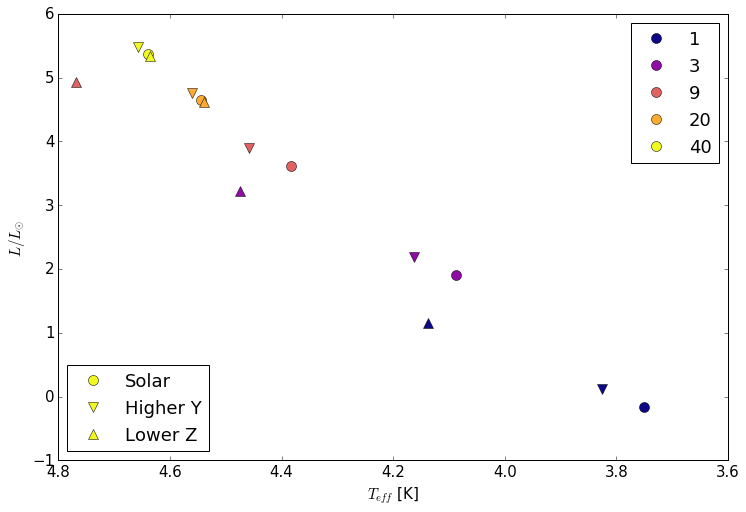

In [153]:
# make pretty colors for plot!
colors,scalarmap,cnorm = colorize(np.log10(M))

# Plot
fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(1,1) 
ax0 = plt.subplot(gs[0])
legm = []
for i in range(len(M)): 
    l1, = ax0.plot(logT[i],logL[i], 'o', lw=2.0, c=colors[i], label=M[i], ms=10)  
    l2, = ax0.plot(logT_scale[0,i],logL_scale[0,i], "v", lw=2.0, c=colors[i], ms=10)
    l3, = ax0.plot(logT_scale[1,i],logL_scale[1,i], "^", lw=2.0, c=colors[i], ms=10)
    legm.append(l1)

ax0.invert_xaxis()
ax0.set_xlabel(r'$T_{eff}$ [K]')
ax0.set_ylabel(r"$L/L_{\odot}$")
leg1 = ax0.legend(legm, ["1", "3", "9", "20", "40"], loc=1, numpoints=1)
leg2 = plt.legend([l1, l2, l3], ["Solar", "Higher Y", "Lower Z"], loc=3, numpoints=1)
plt.gca().add_artist(leg1)
plt.show();

## Problem 14.1  
**Verify that the MS lifetimes of stars M>1.2 solar masses increases in the way we expect for stars with convective cores. Do this for stars with Z=0.02 (solar) and M=120, 25, 5, 1, and 0.8 solar masses. Use the tables in Appendix C2 where $q_{cc} =$ mass fraction contained in the covective core at t=0. Compare results with the data in the lower part of the tables and comment and explain the differences.**  

>If we use the mass fraction contained in the convective core at t=0 as the fraction of the stellar mass that participates in fusion, then the nuclear timescale should give us the MS lifetimes of stars with convective cores. For stars below 1.0 $M_{\odot}$ that do not have convective cores, I will adopt a value of $f_M = 0.1$.

$$\tau_{nuc} \sim f_M M c^2 \epsilon_n / L$$

In [206]:
# Define quantities from appendix C2
Mass = np.array([120., 25., 5., 1., 0.8]) * Msun
fM = np.array([0.867, 0.555, 0.314, 0.1, 0.1])
eH = 0.007
L = 10.**np.array([6.252, 4.897, 2.740, -0.163, -0.554]) * Lsun
tH = np.array([2.561e6, 6.408e6, 9.446e7, 9.845e9, 2.503e10])

In [201]:
t_nuc = fM * Mass * c**2 * eH / L / 3600. / 24. / 365.25

In [230]:
print "Mass [Msun]   ", "t_nuc [yr]   ", "t_MS [yr]   ", "t_nuc/t_MS"
print "-----------   ", "----------   ", "---------   ", "----------"
for i in range(len(Mass)):
    print ' %.2E      ' % Mass[i], '%.2E    ' %t_nuc[i], '%.2E       ' %tH[i], '%.2f' %(t_nuc[i]/tH[i])

Mass [Msun]    t_nuc [yr]    t_MS [yr]    t_nuc/t_MS
-----------    ----------    ---------    ----------
 2.40E+35       6.46E+06     2.56E+06        2.52
 5.00E+34       1.95E+07     6.41E+06        3.04
 1.00E+34       3.17E+08     9.45E+07        3.35
 2.00E+33       1.61E+10     9.84E+09        1.64
 1.60E+33       3.18E+10     2.50E+10        1.27


>As we expect, we see that higher mass stars have shorter lifetimes. I don't know anything about the models in appendix C2, but the nuclear timescales using the convective regions are systematically longer than the MS lifetimes in the models. It does make sense that convection allows the core to access fresh hydrogen, thus increasing it's lifetime beyond what you would expect if the core was not convective. 